<font size=6>**SOMMARIO DEL NOTEBOOK**</font>

In questo notebook andiamo a testare l'efficacia del modello pre-addestrato EfficientNetV2S, fornito direttamente da Keras. Proveremo prima la sua versione base estendendolo con i nostri livelli Dense di classificazione, poi applicheremo del Fine Tuning scongelando gli ultimi livelli per ottimizzare ulteriormente le performance.

Infine, è disponibile un modulo per visualizzare le heatmaps in modo da poter apprezzare le regioni dell'immagine che influenzano la decisione del modello.


**Indice:**
*   [Installazioni, import librerie e funzioni utili](#1)
*   [Caricamento del Dataset](#2)
*   [Modello EfficientNetV2S](#3)
*   [Modello EfficientNetV2S + Fine Tuning](#4)
*   [Risultati e confronti](#5)
*   [Visualizzazione Heatmaps](#6)



<a name="1"></a>
# Installazioni, import librerie e funzioni utili

In [ ]:
! pip install tensorflow-gpu==2.8.3

In [1]:
from google.colab import drive, files
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import pandas as pd                                                               # per gestire la serializzazione/deserializzazione dei risultati
import numpy as np                                                                # per gestire gli ndarray con le feature maps
import shutil                                                                     # per fare spostamenti e copie tra drive e colab
import os                                                                         # per gestire le cartelle dei dataset

In [2]:
drive.mount("/content/drive", force_remount=True)                                 # montiamo il drive per prelevare i dataset

Mounted at /content/drive


Le seguenti funzioni servono per salvare/caricare facilmente le history, le evaluation e i pesi del modello su Google Drive.

In [3]:
result_folder_path = "/content/drive/MyDrive/DeepBrainMRI/Risultati vari/EfficientNetV2S"
saved_weights_path = "/content/drive/MyDrive/DeepBrainMRI/Saved Weights/EfficientNetV2S"
dataset_directory = ''

def saveHistory(history, nomeFile):                                               # funzione per salvare la history di un addestramento
  if not os.path.exists(result_folder_path):
     os.makedirs(result_folder_path)
  history_df = pd.DataFrame.from_dict(history.history)
  history_df.to_csv(result_folder_path + f"/{dataset_directory}_{nomeFile}_history.csv", index=False)

def loadHistory(nomeFile):                                                        # funzione per caricare la history di un addestramento
  if os.path.exists(result_folder_path):
    return pd.read_csv(f"{result_folder_path}/{dataset_directory}_{nomeFile}_history.csv").to_dict()
  else:
    raise Exception("Cartella inesistente!")

def saveEvaluation(loss, acc, f1, nomeFile):                                      # funzione per salvare il risultato di un evaluation
  if not os.path.exists(result_folder_path):
     os.makedirs(result_folder_path)
  evaluation = {}
  evaluation['loss'] = loss
  evaluation['accuracy'] = acc
  evaluation['f1_score'] = f1
  evaluation_df = pd.DataFrame.from_dict(evaluation)
  evaluation_df.to_csv(result_folder_path + f"/{dataset_directory}_{nomeFile}_evaluation.csv", index=False)

def loadEvaluation(nomeFile):                                                     # funzione per caricare il risultato di un evaluation
  if os.path.exists(result_folder_path):
    return pd.read_csv(f"{result_folder_path}/{dataset_directory}_{nomeFile}_evaluation.csv").to_dict()
  else:
    raise Exception("Cartella inesistente!")

def saveWeights(nomeFile):                                                        # funzione per salvare il file dei pesi su drive
  if not os.path.exists(saved_weights_path):
    os.makedirs(saved_weights_path)
  shutil.copy(nomeFile, f"{saved_weights_path}")

def loadWeights(nomeFile):                                                        # funzione per caricare il file dei pesi da drive
  if os.path.exists(saved_weights_path):
    shutil.copy(f"{saved_weights_path}/{nomeFile}", '/content/')
  else:
    raise Exception("Cartella inesistente!")

<a name="2"></a>
# Caricamento del dataset

Impostiamo dei valori costanti per la corretta esecuzione del notebook.

In [4]:
base_datasets_path = "/content/drive/My Drive/DeepBrainMRI/Datasets/"

BATCH_SIZE = 32                                                                   # specifichiamo la grandezza dei batch
IMAGE_WIDTH, IMAGE_HEIGHT = 299, 299                                              # la dimensione delle immagini di default per l'EfficientNetV2S è 299×299

IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)                                      # ci sono 3 canali perché importiamo come RGB

SEED = 2680                                                                       # seme per poter replicare le stesse condizioni del dataset

Sceliere il tipo di dataset (train_data) che si vuole importare:

In [5]:
dataset_directory = 'under+aug'                                 # dataset con undersampling e data augmentation

In [ ]:
dataset_directory = 'only_under'                                # dataset con SOLO undersampling

In [ ]:
dataset_directory = 'only_aug'                                  # dataset con solo data augmentation

In [6]:
dataset_directory = 'base'                                      # dataset base (già ridimensionato)

Istruzioni per importare il dataset. Sono richiesti fino a 2-3 minuti a seconda del dataset.

In [7]:
destinazione = f"/content/dataset/{dataset_directory}"

if dataset_directory != 'base':
  shutil.copytree(f'{base_datasets_path}{dataset_directory}', f'{destinazione}/Training', dirs_exist_ok=True)     # train_data pre-processato
else:
  shutil.copytree(f'{base_datasets_path}DATASET_BASE/Training', f'{destinazione}/Training', dirs_exist_ok=True)   # train_data base
print(f"Ho importato il training set \'{dataset_directory}\' nella cartella {destinazione}/Training")

shutil.copytree(f'{base_datasets_path}DATASET_BASE/Testing', f'{destinazione}/Testing', dirs_exist_ok=True)       # importa il test_data
print(f"Ho importato il test set nella cartella {destinazione}/Testing")

Ho importato il training set 'base' nella cartella /content/dataset/base/Training
Ho importato il test set nella cartella /content/dataset/base/Testing


In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = f'{destinazione}/Training',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    crop_to_aspect_ratio=True,
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory = f'{destinazione}/Testing',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    crop_to_aspect_ratio=True,
)

class_names = test_data.class_names
print("\nHo caricato train_data e test_data dalla cartella %s" % destinazione)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.

Ho caricato train_data e test_data dalla cartella /content/dataset/base


Stampando la shape di un batch di immagini possiamo notare che corrisponderà a:

(**BATCH_SIZE**, **IMAGE_WIDTH**, **IMAGE_HEIGHT**, **3**)

In [ ]:
for img, lbl in train_data.take(1):
  print(img.shape)

(32, 299, 299, 3)


<a name="3"></a>
# Modello convolutivo pre-addestrato: EfficientNetV2S

In [ ]:
conv_base = tf.keras.applications.EfficientNetV2S(
    weights="imagenet",
    include_top=False,  # include_top si riferisce all'inclusione (o meno) dei livelli densamente connessi di classificazione
    input_shape=IMAGE_SHAPE,
    pooling = 'max', #più adatto al nostro tipo di problema, per prendere le caratteristiche più importanti dell'input
    include_preprocessing=True
)

In [ ]:
conv_base.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 299, 299, 3)          0         ['input_9[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 150, 150, 24)         648       ['rescaling_5[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 150, 150, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                

Estraiamo le feature maps in modo da poter allenare i layer dense direttamente su queste.

In [ ]:
def get_features_and_labels(dataset):                                            # funzione per pre-processare in anticipo il dataset
 all_features, all_labels = [], []

 for images, labels in dataset:
  features = conv_base.predict(images, verbose=0)                                       # estrae le feature maps
  all_features.append(features)                                                         # le salviamo in una lista
  all_labels.append(labels)

 return np.concatenate(all_features), np.concatenate(all_labels)

Eseguiamo il pre-processing per il training set e per il test set.

In [ ]:
train_features, train_labels = get_features_and_labels(train_data)
test_features, test_labels = get_features_and_labels(test_data)

Ricaviamo una piccola parte (20%) dal training set per usarla come validation set.

In [ ]:
samples = len(train_features)
samples *= 0.2
samples= int(samples)

val_features = train_features[:samples]
train_features = train_features[samples:]

val_labels = train_labels[:samples]
train_labels = train_labels[samples:]

In [ ]:
inputs = tf.keras.Input(shape=(1280))                                            # questa volta l'input shape sarà uguale alla shape dell'output dell'ultimo livello dell'EfficientNetV2S

x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)

output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, output)                                           # crea il modello

In [ ]:
model.compile(loss='kullback_leibler_divergence', optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]) # Compila il modello

In [ ]:
model.summary() # riassunto del modello

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="EfficientNetV2S.keras", save_best_only=True, monitor="val_loss"),  # salviamo i pesi dell'epoca con la val_loss minore
    #tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, start_from_epoch=40, verbose=1)         # dopo tre epoche in cui la val_loss non è migliorata si ferma
]

In [ ]:
EPOCHE = 50

history = model.fit(train_features, train_labels, epochs=EPOCHE, validation_data=(val_features, val_labels), callbacks=callbacks)

In [ ]:
saveHistory(history, 'EfficientNetV2S')

In [ ]:
model = tf.keras.models.load_model("EfficientNetV2S.keras")

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_features, test_labels)

In [ ]:
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-score: {np.mean(test_f1)}")

Loss: 0.17575863003730774
Accuracy: 0.936689555644989
Precision: 0.9414032101631165
Recall: 0.9313501119613647
F1-score: 0.9330239295959473


In [ ]:
print("Inserire il nome del file di salvataggio:")
name = input()
model.save_weights(name)
saveWeights(name)

Inserire il nome del file di salvataggio:
EfficientNet_FIERO.keras


In [14]:
print("Inserire il nome del file di salvataggio:")
name = input()
loadWeights(name)
model.load_weights(name)

Inserire il nome del file di salvataggio:
EfficientNet_FIERO.keras


<a name="4"></a>
# Modello Convolutivo pre-addestrato: EfficientNetV2S + Fine tuning

In [9]:
conv_base = tf.keras.applications.EfficientNetV2S(
    weights="imagenet",
    include_top=False,  # include_top si riferisce all'inclusione (o meno) dei livelli densamente connessi di classificazione
    input_shape=IMAGE_SHAPE,
    pooling = 'max', #più adatto al nostro tipo di problema, per prendere le caratteristiche più importanti dell'input
    include_preprocessing=True
)

82420632/82420632 [==============================] - 0s 0us/step


In [10]:
# di default, tutti i pesi addestrabili sono già tutti scongelati
for layer in conv_base.layers[:-49]:           # congeliamo tutti i livelli tranne gli ULTIMI 17 (block14 & block13)
 layer.trainable = False

In [ ]:
conv_base.summary()

In [11]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)                                       # la shape è stata definita durante l'import del dataset

x = conv_base(inputs)                                                            # estrazione delle feature maps dall'EfficientNetV2S

x = tf.keras.layers.Flatten()(x)                                                 # vettorializziamo perché i Dense manipolano solo tensori a una dimensione
x = tf.keras.layers.Dropout(rate=0.25)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.25)(x)

output = tf.keras.layers.Dense(4, activation='softmax')(x)                       # layer di output

model = tf.keras.Model(inputs, output)                                           # crea il modello

In [ ]:
model.summary() # visualizza il riassunto del modello

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="EfficientNetV2SFT.keras", save_best_only=True, monitor="val_loss"),  # salviamo i pesi dell'epoca con la val_loss minore
    #tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1)            # dopo due epoche in cui la val_loss non è migliorata si ferma
]

In [12]:
model.compile(loss='kullback_leibler_divergence', optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]) # Compila il modello

In [13]:
total_batches = tf.data.experimental.cardinality(train_data).numpy()              # calcola il numero totale di batch nel dataset

validation_size = int(0.2 * total_batches)                                        # imposta una percentuale per il validation set (in questo caso 20%)

# separa i dataset di training e validation
validation_data = train_data.take(validation_size)
train_data = train_data.skip(validation_size)

In [ ]:
EPOCHE = 20

historyFT = model.fit(train_data, epochs=EPOCHE, validation_data=validation_data, callbacks=callbacks)

Epoch 1/20
144/144 [==============================] - 77s 373ms/step - loss: 2.0544 - accuracy: 0.6988 - precision_7: 0.7302 - recall_7: 0.6583 - f1_score: 0.6708 - val_loss: 0.3000 - val_accuracy: 0.8821 - val_precision_7: 0.9022 - val_recall_7: 0.8652 - val_f1_score: 0.8780
Epoch 2/20
144/144 [==============================] - 52s 346ms/step - loss: 0.3783 - accuracy: 0.8506 - precision_7: 0.8769 - recall_7: 0.8317 - f1_score: 0.8434 - val_loss: 0.1939 - val_accuracy: 0.9259 - val_precision_7: 0.9312 - val_recall_7: 0.9187 - val_f1_score: 0.9235
Epoch 3/20
144/144 [==============================] - 54s 352ms/step - loss: 0.2637 - accuracy: 0.9020 - precision_7: 0.9133 - recall_7: 0.8920 - f1_score: 0.8979 - val_loss: 0.1299 - val_accuracy: 0.9509 - val_precision_7: 0.9551 - val_recall_7: 0.9500 - val_f1_score: 0.9497
Epoch 4/20
144/144 [==============================] - 53s 352ms/step - loss: 0.1839 - accuracy: 0.9336 - precision_7: 0.9392 - recall_7: 0.9279 - f1_score: 0.9311 - val_

In [ ]:
saveHistory(historyFT, 'EfficientNetV2S_FT_under+aug')

In [ ]:
model = tf.keras.models.load_model("EfficientNetV2SFT.keras") # ricarichiamo i pesi migliori prima della valutazione finale

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_data)
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-score: {np.mean(test_f1)}")

41/41 [==============================] - 10s 214ms/step - loss: 0.0517 - accuracy: 0.9908 - precision_7: 0.9908 - recall_7: 0.9908 - f1_score: 0.9904
Loss: 0.05174161493778229
Accuracy: 0.9908466935157776
Precision: 0.9908466935157776
Recall: 0.9908466935157776
F1-score: 0.9903998970985413


In [ ]:
saveEvaluation(test_loss, test_accuracy, test_f1, 'EfficientNetV2S_FT_under+aug')

<a name="5"></a>
# Confronto tra le varie versioni

In [ ]:
acc = historyFT.history['accuracy']
val_acc = historyFT.history['val_accuracy']
loss = historyFT.history['loss']
val_loss = historyFT.history['val_loss']
f1_score = []
val_f1_score = []

epochs = range(1, len(acc) + 1)

for i in range(len(acc)):
  f1_score.append(np.mean(historyFT.history['f1_score'][i]))
  val_f1_score.append(np.mean(historyFT.history['val_f1_score'][i]))

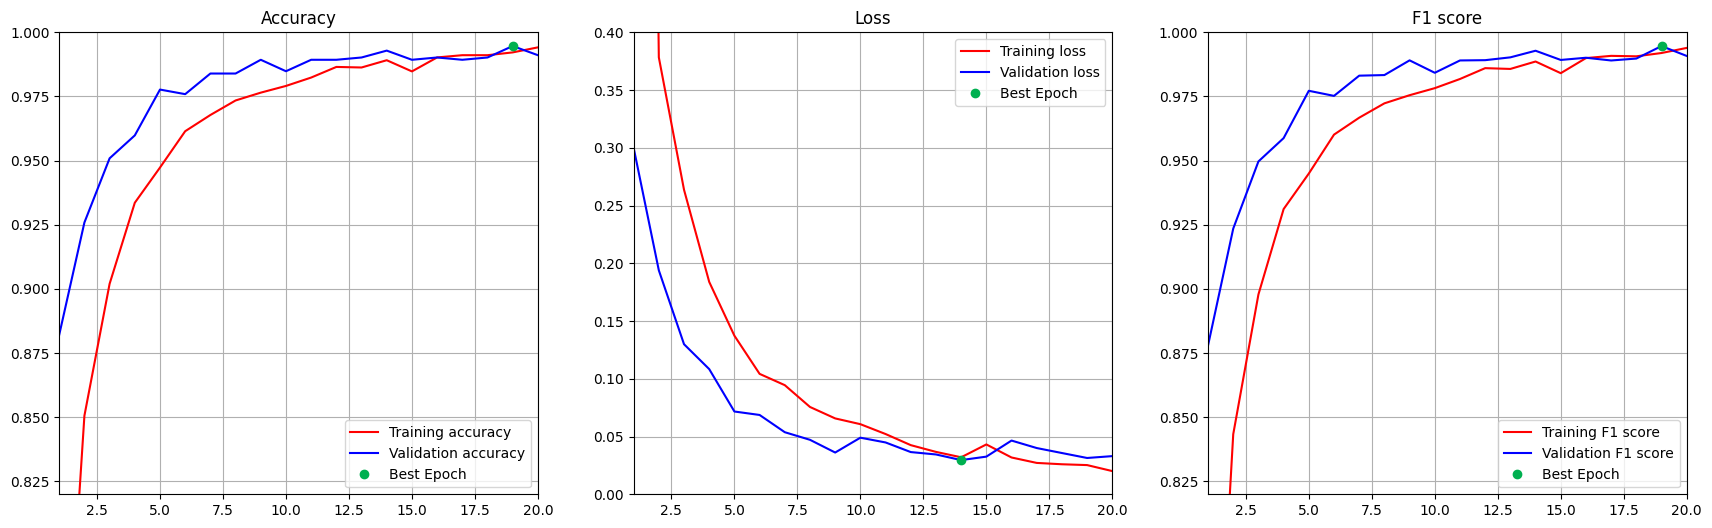

In [ ]:
# Creazione del grafico per l'accuracy
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')

plt.plot(np.argmax((val_acc))+1, np.max(val_acc), 'o', color='#00b050', label='Best Epoch')

plt.legend()
plt.xlim([1, np.max(epochs)])
plt.ylim([0.82, 1])
plt.grid()

# Creazione del grafico per il loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')

plt.plot(np.argmin((val_loss))+1, np.min(val_loss), 'o', color='#00b050', label='Best Epoch')

plt.legend()
plt.xlim([1, np.max(epochs)])
plt.ylim([0, 0.4])
plt.grid()

# Creazione del grafico per l'F1 score
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, 'r', label='Training F1 score')
plt.plot(epochs, val_f1_score, 'b', label='Validation F1 score')
plt.title('F1 score')

plt.plot(np.argmax((val_f1_score))+1, np.max(val_f1_score), 'o', color='#00b050', label='Best Epoch')

plt.legend()
plt.xlim([1, np.max(epochs)])
plt.ylim([0.82, 1])
plt.grid()

plt.show()

<a name="6"></a>
#Heat Maps

Prima definiamo una funzione che trasforma l'immagine in un array e lo pre-processa usando la funzione di EfficientNetV2

In [ ]:
def get_img_array(img_path, target_size):
  img = tf.keras.utils.load_img(img_path, target_size=target_size)
  array = tf.keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = tf.keras.applications.efficientnet_v2.preprocess_input(array)
  return array

Dobbiamo costruire un modello che mappi le attivazioni dell'ultimo strato convoluzionale con le previsioni finali della classe.

In [141]:
last_conv_layer_name = "top_activation"                                                   # nome dell'ultimo livello convolutivo (dentro efficientnetv2)

efficientnet_model = model.get_layer('efficientnetv2-s')                                  # estraggo efficientnet dal modello (si parte dal modello con fine tuning)

last_conv_layer = efficientnet_model.get_layer(last_conv_layer_name)                      # estraggo il livello interessato

last_conv_layer_model = tf.keras.Model(efficientnet_model.input, last_conv_layer.output)  # creiamo il modello con l'ultimo livello convolutivo

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])

x = classifier_input
x = efficientnet_model.get_layer('max_pool')(x)                                           # estriamo anche l'ultimo livello di pooling da efficientnetv2
x = model.get_layer('flatten')(x)
x = model.get_layer('dropout')(x)
x = model.get_layer('dense')(x)                                                           # costruiamo il modello estraendo anche i Dense di classificazione dal modello col fine tuning
x = model.get_layer('dropout_1')(x)
x = model.get_layer('dense_1')(x)

classifier_model = tf.keras.Model(classifier_input, x)                                    # il modello è pronto

Inserire il path dell'immagine che si vuole classificare e analizzare:

In [148]:
img_path = "/content/dataset/base/Testing/pituitary/Te-pi_0011.jpg"
showHeatMaps = True                                                              # è possibile scegliere se si vuole visualizzare l'heatmap appena la si estrae

Applichiamo la tecnica Grad-CAM per estrarre una HeatMap e vedere quali zone dell'immagine hanno influenzato la decisione del modello.

In [149]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(get_img_array(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))) # Calcolare le attivazioni dell'ultimo strato convolutivo
  tape.watch(last_conv_layer_output)                                              # facciamole osservare al tape
                                                                                  # Recuperiamo il canale di attivazione corrispondente alla classe superiore prevista
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)                  # gradiente della classe maggiormente prevista rispetto alla mappa delle caratteristiche in uscita dall'ultimo strato convoluzionale

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()                      # vettore in cui ogni voce rappresenta l'intensità media del gradiente per un determinato canale

last_conv_layer_output = last_conv_layer_output.numpy()[0]                        # Quantifica l'importanza di ciascun canale rispetto alla classe superiore prevista
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]                              # Moltiplica ogni canale nell'output dell'ultimo strato convoluzionale per "l'importanza (peso) di questo canale"
heatmap = np.mean(last_conv_layer_output, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

if showHeatMaps:                                                                  # in base alla variabile valorizzata nella cella prima
  plt.matshow(heatmap)

Una volta estratta la heatmap la prepariamo per poterla sovrapporre all'immagine originale e visualizzarla nel plot.

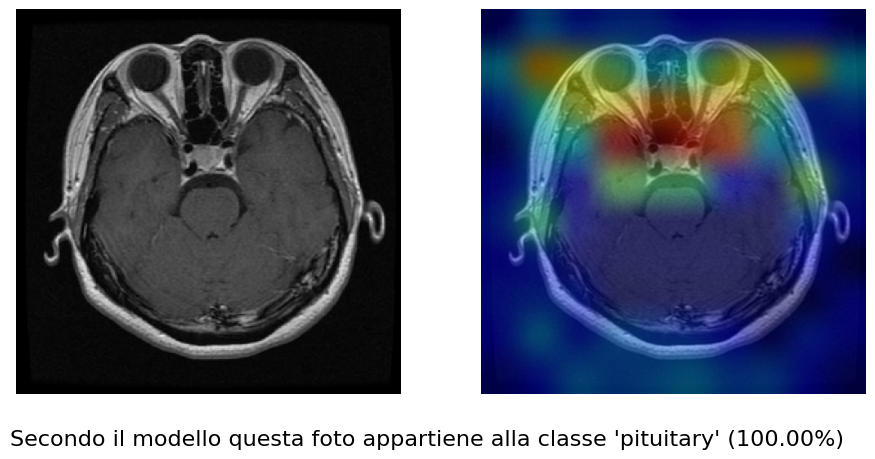

In [160]:
img = tf.keras.utils.load_img(img_path, color_mode='grayscale')
img = tf.keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
jet = plt.colormaps.get_cmap('jet')                                               # Utilizzare la colormap "jet" per ricolorare la mappa di calore.
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * 0.7 + img                                        # Sovrapponiamo la heatmap all'immagine originale, con il 70% di opacità

superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

fig = plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
img_array = get_img_array(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))

plt.axis("off")
plt.imshow(tf.keras.utils.load_img(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT)))

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.axis("off")

fig.text(0.5, 0, f"Secondo il modello questa foto appartiene alla classe \'%s\' (%.2f%%)" % (class_names[np.argmax(preds[0])], np.max(preds[0])*100), ha='center', va='bottom', fontsize='16')

plt.show()

In [140]:
print("Lista di tutte le probabilità per ogni classe")
for i, prob in enumerate(preds[0]):
        print(f"- %s: \t%.5f%%" % (class_names[i], prob*100))

Lista di tutte le probabilità per ogni classe
- glioma: 	0.00002%
- meningioma: 	0.00001%
- notumor: 	0.00000%
- pituitary: 	99.99996%


Download dell'immagine a cui è stata applicata la heatmap:

In [ ]:
print("Inserire il nome dell'immagine per salvarla:")
nome = input()
save_path = f"{nome}.jpg"
superimposed_img.save(save_path)
files.download(save_path)